In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import sys
import pandas as pd

import pickle
import glob
import re
import yaml
import torch
import json

sys.path.append("/private/home/tcai2718/luckmatters5/catalyst")
from visualization.utils import load_data, load_stats, convert_stats_to_summary

In [3]:
from tqdm import tqdm

In [4]:
#roots = ["/checkpoint/yuandong/outputs/2019-12-01/23-13-37/",
#         "/checkpoint/yuandong/outputs/2019-12-01/23-12-47/"]
#roots = ['/checkpoint/tcai2718/catalyst/test_save_student/2019-12-04/15-59-07']
roots = ['/checkpoint/yuandong/outputs/2019-12-05/21-59-59',
         '/checkpoint/yuandong/outputs/2019-12-05/22-00-55']
#ds = [load_data(root, stats_filename="summary.pth") for root in roots]

In [5]:
import logging
logging.disable()

In [6]:
ds = []
for root in roots:
    ds.append(load_data(root, stats_filename="summary.pth", use_tqdm=True))

100%|██████████| 210/210 [00:20<00:00, 10.19it/s]


In [7]:
# directional diff between dictionaries
def dictdiff(a, b):
    return dict([ (k, (a[k], b[k])) for k in a.keys() if k in b.keys() and a[k] != b[k] ])

# like dictdiff but only the keys
def diffkeys(a, b):
    return set([k for k in a.keys() if k in b.keys() and a[k]!=b[k]])

# all keys that are different
def diffkeys_all(d):
    return set.union(*[ diffkeys(d[0]['args'], dx['args']) for dx in d])

# unique values per key
def unique_vals(key, d):
    return set([ dx['args'][key] for dx in d ])

flatten = lambda l: [item for sublist in l for item in sublist]

In [8]:
ds2 = flatten(ds)
dk2 = diffkeys_all(ds2)
for dk in dk2:
    print(dk, unique_vals(dk, ds2))

random_dataset_size {20000, 100000, 200000, 500000, 1000000, 10000, 50000}
node_multi {2, 10, 5}
optim_method {'sgd', 'adam'}
seed {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
lr {'0-0.01', '0-0.2-20-0.1'}


In [19]:
for dk in ['bn','bn_affine']:
    print(dk, unique_vals(dk, ds2))

bn {False}
bn_affine {False}


In [9]:
def data_to_dicts(data, keys, stats_func):
    results = []
    for i, d in enumerate(data):
        args = d["args"]
        entry = { k : getattr(args, k) if hasattr(args, k) else args[k] for k in keys } 
        # also value. 
        entry.update(stats_func(d))
        results.append(entry)
    return results

import math

def extractor(d):
    stats = d["stats"]
    
    result = dict()
    for i in range(4):
        result[f"rho-{i}"] = stats[-1]["eval_corrs"][i].max(dim=0)[0].mean().item()
    if 'eval_ce_loss_teacher' in stats[-1].keys():
        result["eval_loss"] = stats[-1]["eval_ce_loss_teacher"]
    if 'train_ce_loss_teacher' in stats[-1].keys():
        result["train_loss"] = stats[-1]["train_ce_loss_teacher"]
    if 'train_mse_loss' in stats[-1].keys():
        result['train_loss'] = stats[-1]['train_mse_loss']
    if 'eval_mse_loss' in stats[-1].keys():
        result['eval_loss'] = stats[-1]['eval_mse_loss']
        
    # Compute weight change by loading student models. 
    result["path"] = os.path.basename(d["path"])
    
    last_epoch = stats[-1]['iter']
    
#     init_model = torch.load(os.path.join(d["path"], "student-0.pt"))
#     final_model = torch.load(os.path.join(d["path"], f"student-{last_epoch}.pt"))
    
#     # compute their weight difference. 
#     init_dict = init_model.state_dict()
#     final_dict = final_model.state_dict()
    
#     max_diff = 0
#     diff = 0
#     diff_sqr = 0
#     num_param = 0
#     for k, v in init_dict.items():
#         if 'weight' not in k and 'bias' not in k: continue
#         v2 = final_dict[k]
#         this_diff = (v2 - v).norm().item()
#         diff += this_diff
#         diff_sqr += this_diff ** 2
#         max_diff = max(max_diff, this_diff)
#         num_param += v.numel()
    
#     result["weight_change_mean"] = diff / num_param
#     result["weight_total_change"] = diff
#     result["weight_change_std"] = math.sqrt(diff_sqr / num_param - (diff / num_param) ** 2)
#     result["weight_max_change"] = max_diff
    result["last_epoch"] = last_epoch
    return result

#dicts_l = [data_to_dicts(d, list(dk2), extractor) for d in ds]

In [10]:
dicts_l = []
for d in tqdm(ds):
    dicts_l.append(data_to_dicts(d, list(dk2), extractor))

100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


In [11]:
df = pd.concat([pd.DataFrame(dicts) for dicts in dicts_l])

In [12]:
def plot_loss(df2, title='', ax=None):
    if ax is None:
        ax = plt.gca()

    df2.plot(logx=True, y="train_loss", ax=ax)
    df2.plot(logx=True, y="eval_loss", ax=ax)

    ax.set_ylabel("loss")
    ax.set_title(title)
    ax.legend()

In [13]:
def plot_rhos(df2, title='', ax=None):
    if ax is None:
        ax = plt.gca()

    df2.plot(logx=True, y="rho-0", ax=ax)
    df2.plot(logx=True, y="rho-1", ax=ax)
    df2.plot(logx=True, y="rho-2", ax=ax)
    df2.plot(logx=True, y="rho-3", ax=ax)

    ax.set_ylabel("$\\rho_{mean}$")
    ax.set_title(title)

In [14]:
def loss_str(b):
    if b: return ' cross entropy'
    return ' mse'

In [22]:
ds2[0]['args']['cross_entropy']

False

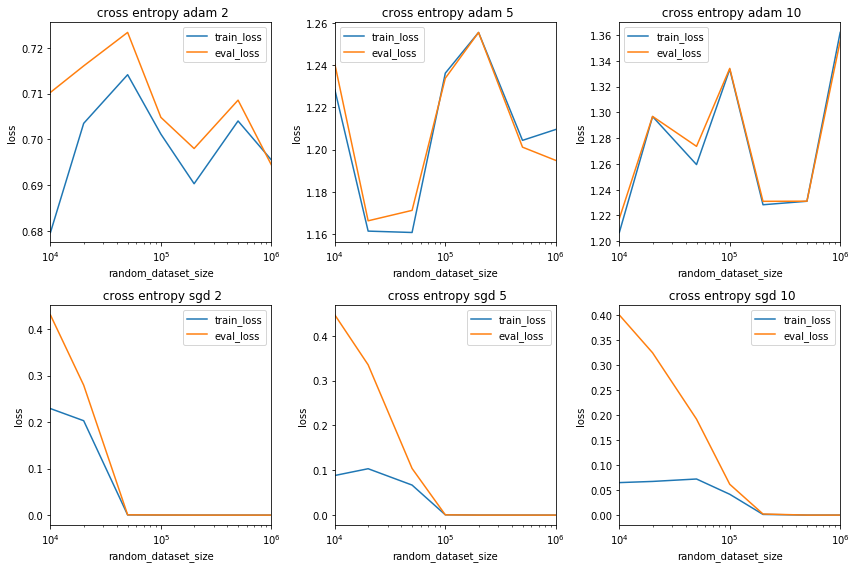

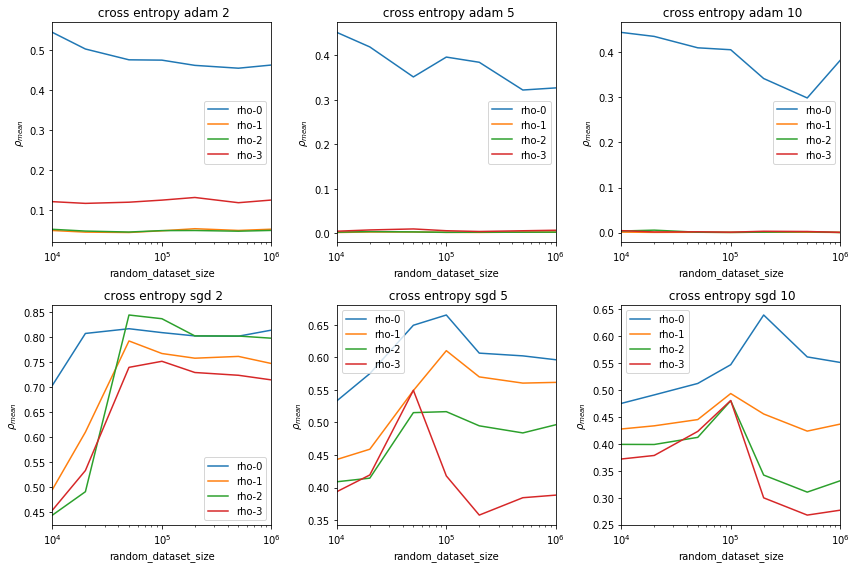

In [18]:
col = 'node_multi'
cvs = df[col].unique()
#for ce in [True,False]:
ce = unique_vals('cross_entropy',ds2)
for fnname, fn in zip(['loss','rhos'],[plot_loss, plot_rhos]):
    fig, ax = plt.subplots(2,len(cvs),figsize=(len(cvs)*4,8))
    for i, optim_method in enumerate(['adam','sgd']):
        for j, cv in enumerate(cvs):
            df2 = df[(df[col] == cv)&(df.optim_method==optim_method)].dropna().groupby(['random_dataset_size']).mean()
            fn(df2,loss_str(ce)+" "+optim_method + ' ' + str(cv), ax=ax[i][j])
    fig.tight_layout()